# Computing power spectra

[![Binder](https://mybinder.org/badge_logo.svg)](https://binder.flatironinstitute.org/v2/user/fvillaescusa/Quijote?filepath=/Tutorials/Power_spectrum.ipynb)

In [1]:
import numpy as np
import readgadget
import readfof
import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL

We start by computing the matter power spectrum of a snapshot

In [2]:
snapshot = '/home/jovyan/Data/Snapshots/s8_p/397/snapdir_004/snap_004' #location of the snapshot

# density field parameters
grid    = 512    #the density field will have grid^3 voxels
MAS     = 'CIC'  #Mass-assignment scheme:'NGP', 'CIC', 'TSC', 'PCS'
verbose = True   #whether to print information about the progress

# power spectrum parameters
axis = 0    #axis along which redshift-space distortions have been placed. In real-space this parameter doesnt matter
threads = 1 #number of openmp threads to compute the power spectrum

First, lets read the particle positions:

In [3]:
# read the redshift, boxsize, cosmology...etc in the header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read positions of the dark matter particles
pos = readgadget.read_block(snapshot, "POS ", [1])/1e3 #positions in Mpc/h

Second, lets compute the density field:

In [4]:
# define the matrix hosting the density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)

# compute the overdensity field
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

# print some information
print('%.3f < delta < %.3f'%(np.min(delta), np.max(delta)))
print('< delta > = %.3f'%np.mean(delta))


Using CIC mass assignment scheme
Time taken = 5.516 seconds

-1.000 < delta < 1044.773
< delta > = -0.000


Third, compute the power spectrum

In [5]:
# compute power spectrum
Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)

# Pk is a python class containing the 1D, 2D and 3D power spectra, that can be retrieved as

# 1D P(k)
k1D      = Pk.k1D
Pk1D     = Pk.Pk1D
Nmodes1D = Pk.Nmodes1D

# 2D P(k)
kpar     = Pk.kpar
kper     = Pk.kper
Pk2D     = Pk.Pk2D
Nmodes2D = Pk.Nmodes2D

# 3D P(k)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole
Pk2     = Pk.Pk[:,1] #quadrupole
Pk4     = Pk.Pk[:,2] #hexadecapole
Pkphase = Pk.Pkphase #power spectrum of the phases
Nmodes  = Pk.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 7.10
Time taken = 12.18 seconds


Lets see how the 3D matter power spectrum looks like:

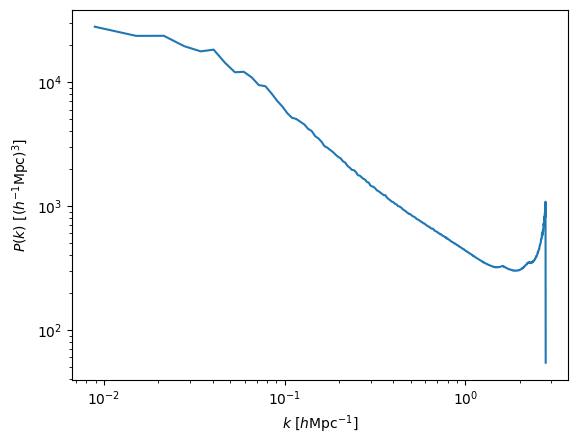

In [6]:
import matplotlib.pyplot as plt
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k~[h{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P(k)~[(h^{-1}{\rm Mpc})^3]$')
plt.plot(k, Pk0)
plt.show()

### Now lets compute the power spectrum of halos with masses above 1e14 in redshift-space

In [7]:
snapdir = '/home/jovyan/Data/Halos/FoF/s8_p/397/' #folder hosting the catalogue
snapnum = 4                                       #number of the catalog (4-->z=0, 3-->z=0.5, 2-->z=1, 1-->z=2, 0-->z=3)

Lets read the halo catalog

In [8]:
# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                          swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s
mass_h = FoF.GroupMass*1e10          #Halo masses in Msun/h
Np_h   = FoF.GroupLen                #Number of CDM particles in the halo. Even in simulations with massive neutrinos, this will be just the number of CDM particles

Lets move halos to redshift-space along the z axis:

In [9]:
# move halos to redshift-space. After this call, pos_h will contain the
# positions of the halos in redshift-space
axis = 2 #axis along which to displace halos
RSL.pos_redshift_space(pos_h, vel_h, BoxSize, Hubble, redshift, axis)

Lets now select all halos with masses above 1e14 Msun/h

In [10]:
indexes = np.where(mass_h>1e14)[0]
pos_h  = pos_h[indexes]
vel_h  = vel_h[indexes]
mass_h = mass_h[indexes]
Np_h   = Np_h[indexes]

print('%.3e < Mass M < %.3e Msun/h'%(np.min(mass_h), np.max(mass_h)))
print('%d halos with masses above 1e14 Msun/h'%pos_h.shape[0])

1.005e+14 < Mass M < 4.589e+15 Msun/h
39096 halos with masses above 1e14 Msun/h


Now lets construct the density field of these halos

In [11]:
# define the matrix hosting the density field
delta_h = np.zeros((grid,grid,grid), dtype=np.float32)

# construct 3D density field
MASL.MA(pos_h, delta_h, BoxSize, MAS, verbose=verbose)

# compute the overdensity field
delta_h /= np.mean(delta_h, dtype=np.float64);  delta_h -= 1.0

# print some information
print('%.3f < delta < %.3f'%(np.min(delta_h), np.max(delta_h)))
print('< delta > = %.3f'%np.mean(delta_h))


Using CIC mass assignment scheme
Time taken = 0.248 seconds

-1.000 < delta < 5290.054
< delta > = 0.000


We can compute the power spectrum now

In [12]:
# compute power spectrum
axis = 2 #we have placed the redshift-space distortions along the z-axis for the halos
Pk_h = PKL.Pk(delta_h, BoxSize, axis, MAS, threads, verbose)

# Pk is a python class containing the 1D, 2D and 3D power spectra, that can be retrieved as

# 1D P(k)
k1D_h      = Pk_h.k1D
Pk1D_h     = Pk_h.Pk1D
Nmodes1D_h = Pk_h.Nmodes1D

# 2D P(k)
kpar_h     = Pk_h.kpar
kper_h     = Pk_h.kper
Pk2D_h     = Pk_h.Pk2D
Nmodes2D_h = Pk_h.Nmodes2D

# 3D P(k)
k_h       = Pk_h.k3D
Pk0_h     = Pk_h.Pk[:,0] #monopole
Pk2_h     = Pk_h.Pk[:,1] #quadrupole
Pk4_h     = Pk_h.Pk[:,2] #hexadecapole
Pkphase_h = Pk_h.Pkphase #power spectrum of the phases
Nmodes_h  = Pk_h.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 7.12
Time taken = 12.30 seconds


Lets compare ths power spectrum with the one from matter:

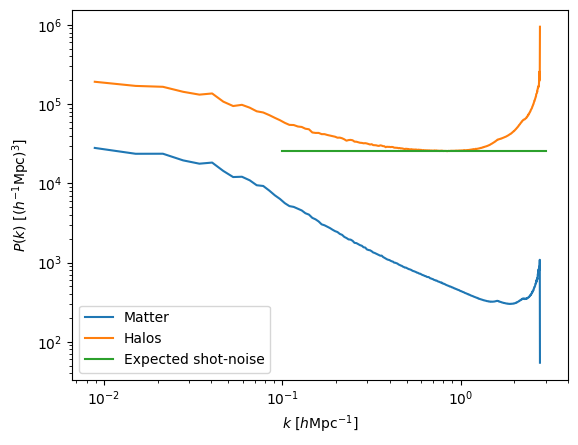

In [13]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k~[h{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P(k)~[(h^{-1}{\rm Mpc})^3]$')
plt.plot(k, Pk0)
plt.plot(k_h, Pk0_h)
plt.plot([1e-1,3],[BoxSize**3/pos_h.shape[0], BoxSize**3/pos_h.shape[0]])
plt.legend(['Matter', 'Halos', 'Expected shot-noise'])
plt.show()

As can be seen, halos are more strongly clustered than matter, as expected as we are taking galaxy clusters with masses above 1e14 Msun/h. On small scales, the power spectrum of halos saturates at the expected shot-noise level. On the smallest scales we have, the power spectrum of both halos and matter is affected by aliasing so should not be trusted.

### Finally, lets show an example of how to compute marked power spectra

Our goal is to compute the power spectrum of halos but instead of giving each halo the same weight, we want to weight each halo by the overdensity of neutrinos from the cosmic neutrino background.

In [14]:
snapshot = '/home/jovyan/Data/Snapshots/Mnu_ppp/261/snapdir_004/snap_004' #location of the snapshot
snapdir  = '/home/jovyan/Data/Halos/FoF/Mnu_ppp/261/'                     #folder hosting the catalogue
snapnum  = 4                                                              #number of the catalog (4-->z=0, 3-->z=0.5, 2-->z=1, 1-->z=2, 0-->z=3)

# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read the neutrino positions
pos_n = readgadget.read_block(snapshot, "POS ", [2])/1e3 #positions in Mpc/h

Now, lets compute the density field of neutrinos

In [15]:
grid = 512

# define the matrix that will contain the neutrino density field
delta_n = np.zeros((grid,grid,grid), dtype=np.float32)

# compute the neutrino density field
MASL.MA(pos_n, delta_n, BoxSize, MAS, verbose=verbose)

# compute the overdensity field
delta_n /= np.mean(delta_n, dtype=np.float64);  delta_n -= 1.0

# print some information
print('%.3f < delta < %.3f'%(np.min(delta_n), np.max(delta_n)))
print('< delta > = %.3f'%np.mean(delta_n))


Using CIC mass assignment scheme
Time taken = 23.728 seconds

-1.000 < delta < 51.771
< delta > = 0.000


Now, lets read the halo catalog

In [16]:
# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                          swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s
mass_h = FoF.GroupMass*1e10          #Halo masses in Msun/h
Np_h   = FoF.GroupLen                #Number of CDM particles in the halo. Even in simulations with massive neutrinos, this will be just the number of CDM particles

We need to compute the overdensity of neutrinos in the location of the dark matter halos. For this we do

In [17]:
# definte the array hosting the neutrino overdensities
delta_n_h = np.zeros(pos_h.shape[0], dtype=np.float32)

# interpolate to find the neutrino overdensity in the positions of the halos
MASL.CIC_interp(delta_n, BoxSize, pos_h, delta_n_h)

Now, we can construct a density field weigthing each halo by its neutrino overdensity

In [18]:
# matrix that will host the density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

# compute the "marked" halo density field
MASL.MA(pos_h, delta, BoxSize, MAS, W=delta_n_h, verbose=verbose)

# print some information about the density field
print('%.3f < delta < %.3f'%(np.min(delta), np.max(delta)))
print('< delta > = %.3f'%np.mean(delta))


Using CIC mass assignment scheme with weights
Time taken = 0.520 seconds

-0.808 < delta < 21.207
< delta > = 0.002


We now compute the power spectrum of this field. This is equivalent to say that we are computing the marked power spectrum of the halos where the mark is the neutrino overdensity

In [19]:
# compute power spectrum
axis = 0 #we are working in real-space, so this value doesnt matter
Pk_h = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)

# Pk is a python class containing the 1D, 2D and 3D power spectra, that can be retrieved as

# 1D P(k)
k1D_h      = Pk_h.k1D
Pk1D_h     = Pk_h.Pk1D
Nmodes1D_h = Pk_h.Nmodes1D

# 2D P(k)
kpar_h     = Pk_h.kpar
kper_h     = Pk_h.kper
Pk2D_h     = Pk_h.Pk2D
Nmodes2D_h = Pk_h.Nmodes2D

# 3D P(k)
k_h       = Pk_h.k3D
Pk0_h     = Pk_h.Pk[:,0] #monopole
Pk2_h     = Pk_h.Pk[:,1] #quadrupole
Pk4_h     = Pk_h.Pk[:,2] #hexadecapole
Pkphase_h = Pk_h.Pkphase #power spectrum of the phases
Nmodes_h  = Pk_h.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 7.23
Time taken = 12.47 seconds


Now lets see how this marked power spectrum looks like:

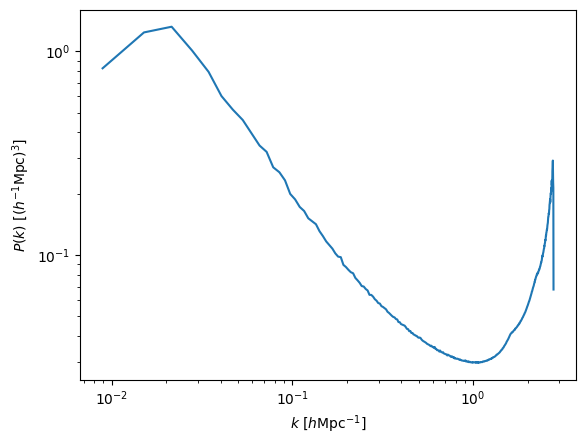

In [20]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k~[h{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P(k)~[(h^{-1}{\rm Mpc})^3]$')
plt.plot(k, Pk0_h)
plt.show()

Pretty weird, right? :)